# Ecological index - Regional and hemispheric AEV distributions to find bin threshold values
- Make value bins for future AEV Index spatial plots
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load data for eco index

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load the Historical and Future Ecoindex Binned Data

In [7]:
file_in = 'ecoindex_historical_future_masked_habitat.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
# keep regional version only
eco_pd = ds_eco.ecoindex_regional_decadal

# mask land
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)

# mask where it's zero because that's out of SIZ
eco_pd = eco_pd.where(eco_pd > 0)

### Load regional masks

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [10]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load shapefiles

In [11]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [12]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures - AEV spatial

In [13]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [14]:
# get lat/lon info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [15]:
# set some plotting info
cmap_in = cmocean.cm.deep
vmin_in = 0.0
vmax_in = 1.0
# set contour levels
levels_in = np.arange(0,1.1,0.1)
levels_in_ctr = np.arange(0,3,1)

In [16]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

In [17]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

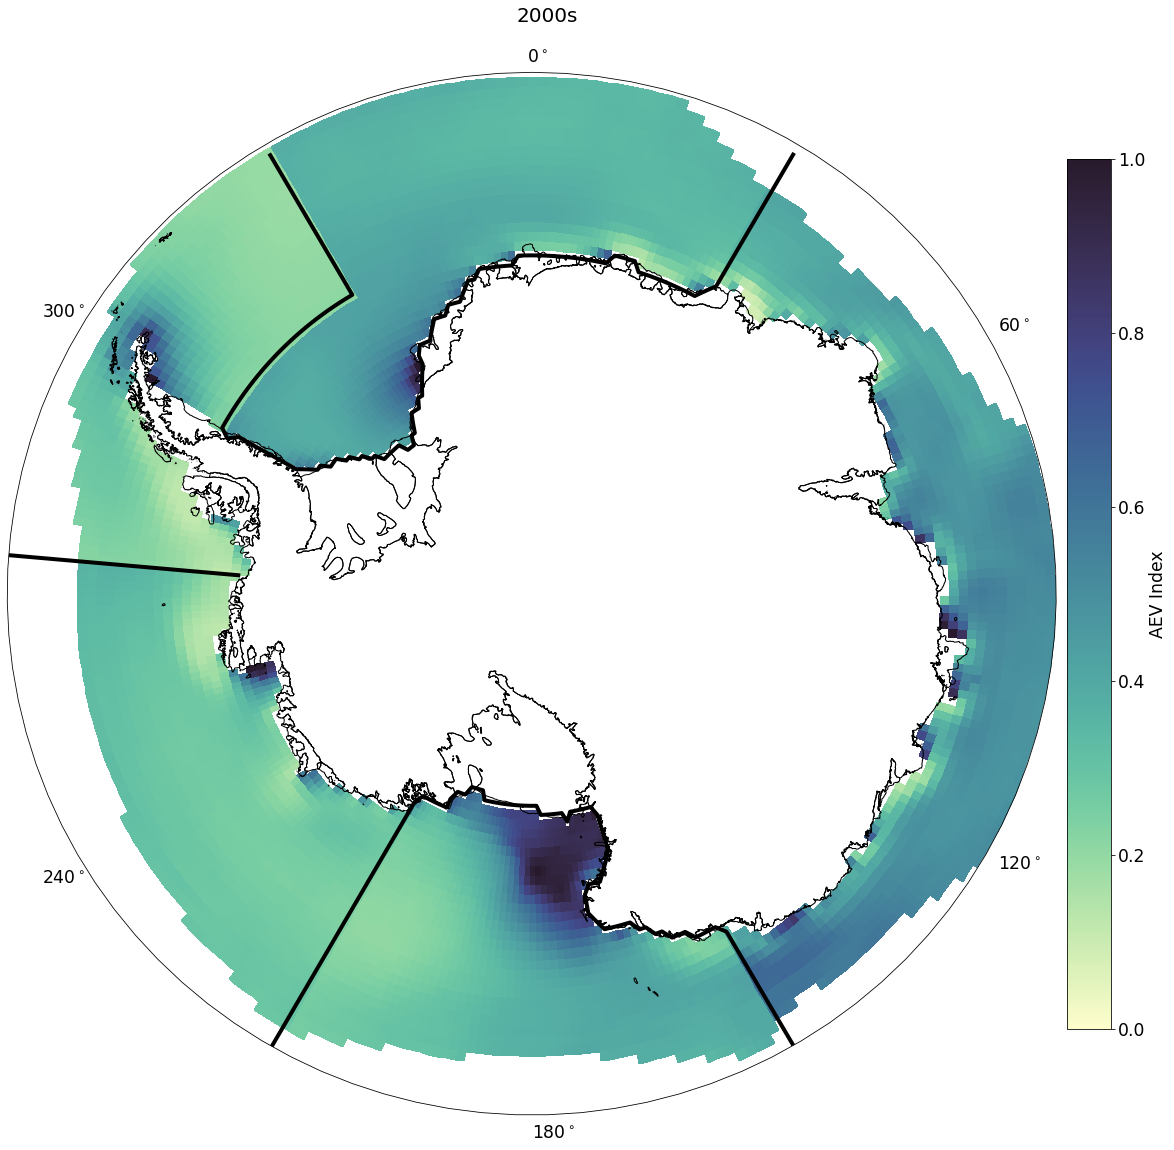

In [18]:
### Plot Regional AEV Index by decade
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2000
dec_str = str(dec)
fout = 'SFigure_AEV_region_'+dec_str

# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

# Finalize figure and save
fig.suptitle(dec_str+'s',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

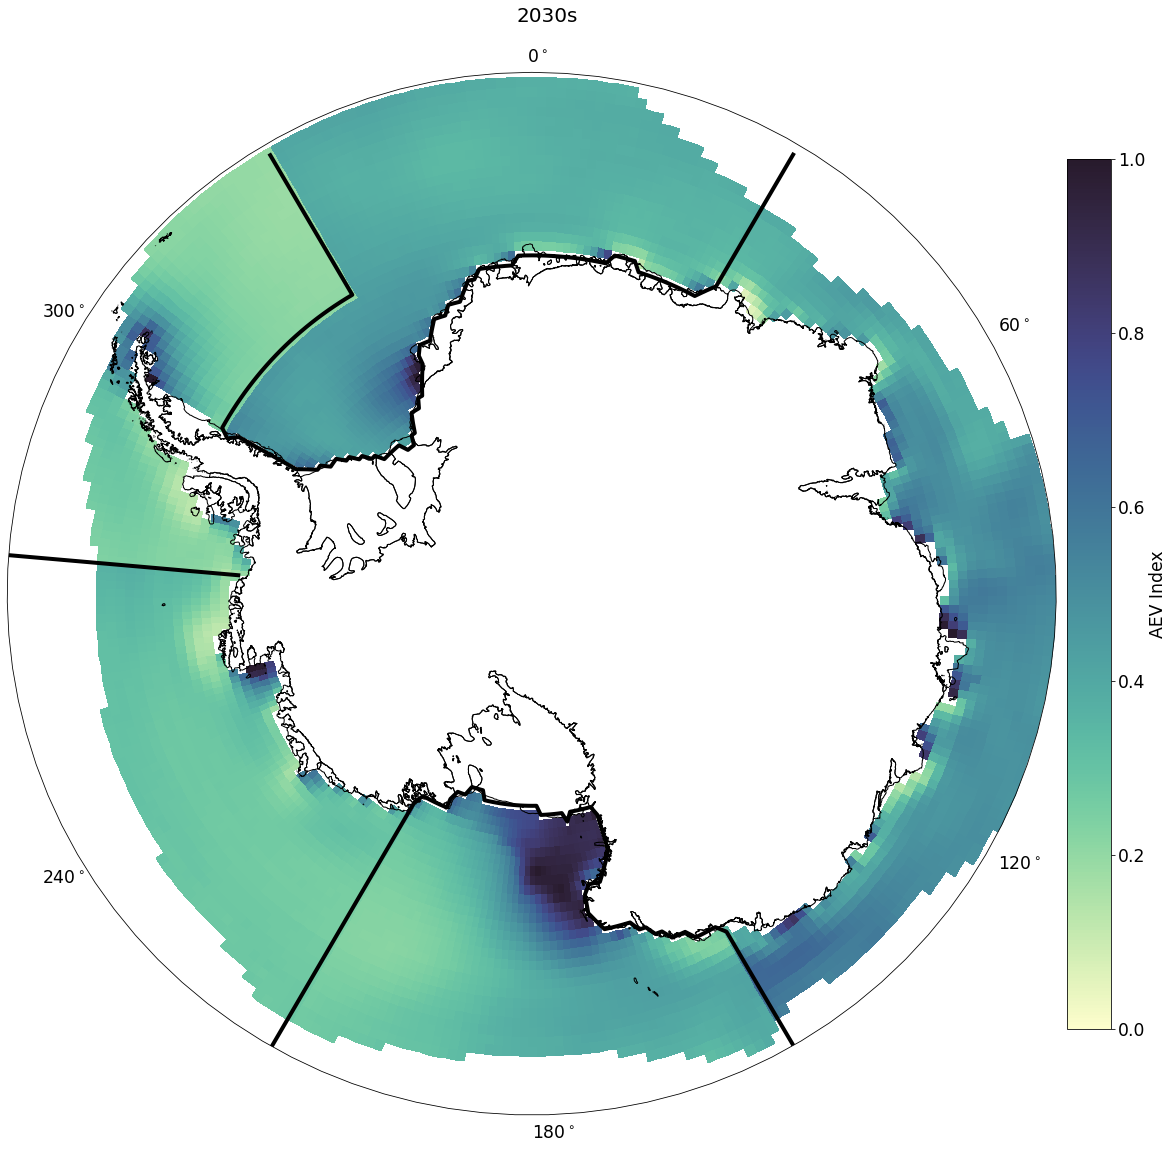

In [19]:
### Plot Regional AEV Index by decade
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2030
dec_str = str(dec)
fout = 'SFigure_AEV_region_'+dec_str

# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

# Finalize figure and save
fig.suptitle(dec_str+'s',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

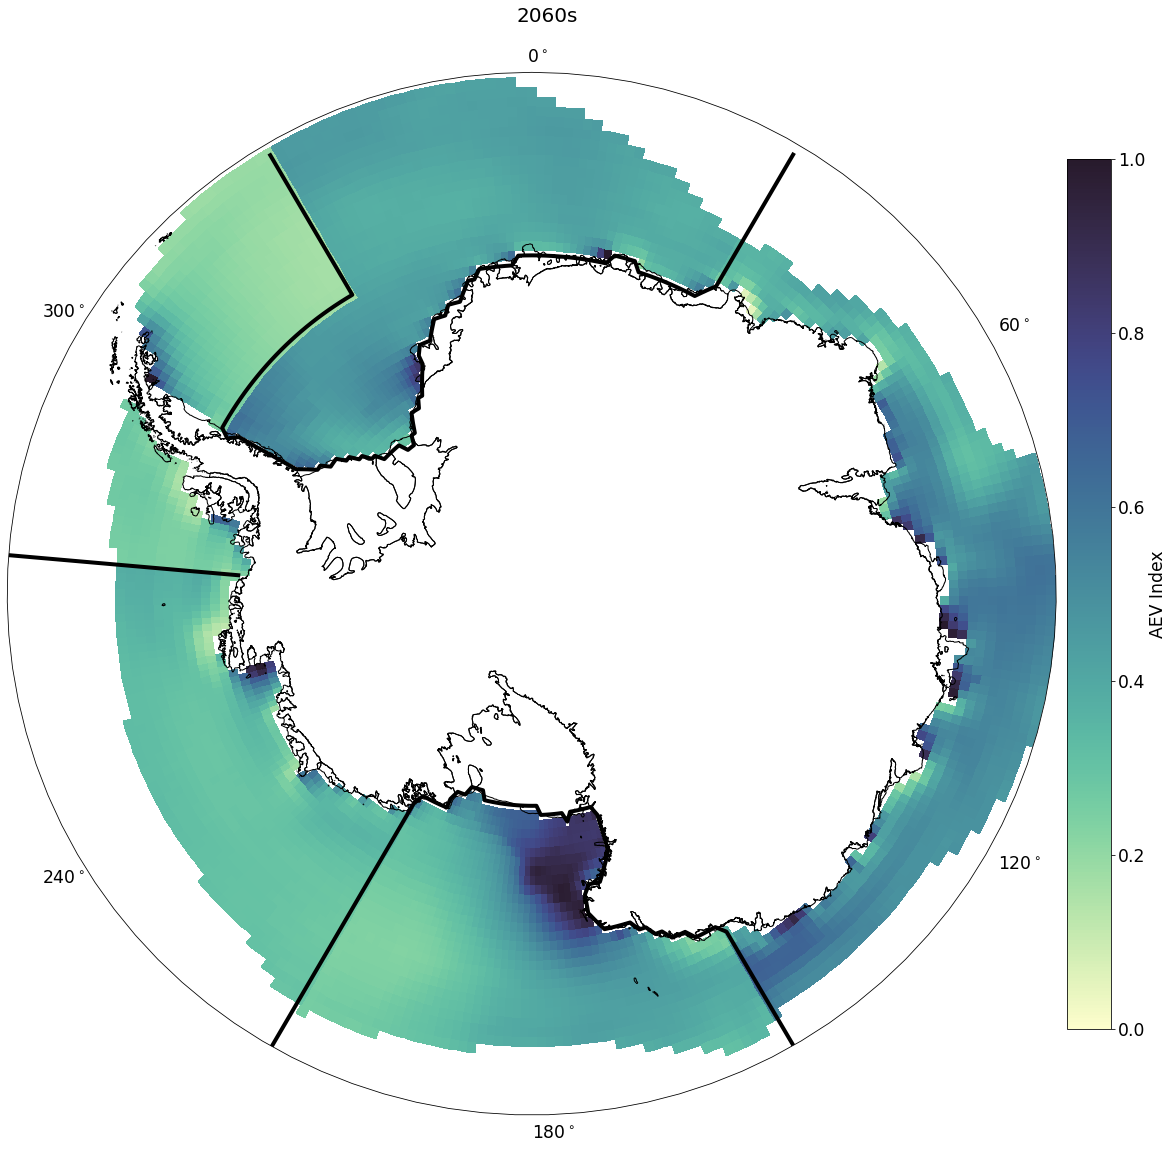

In [20]:
### Plot Regional AEV Index by decade
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2060
dec_str = str(dec)
fout = 'SFigure_AEV_region_'+dec_str

# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

# Finalize figure and save
fig.suptitle(dec_str+'s',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

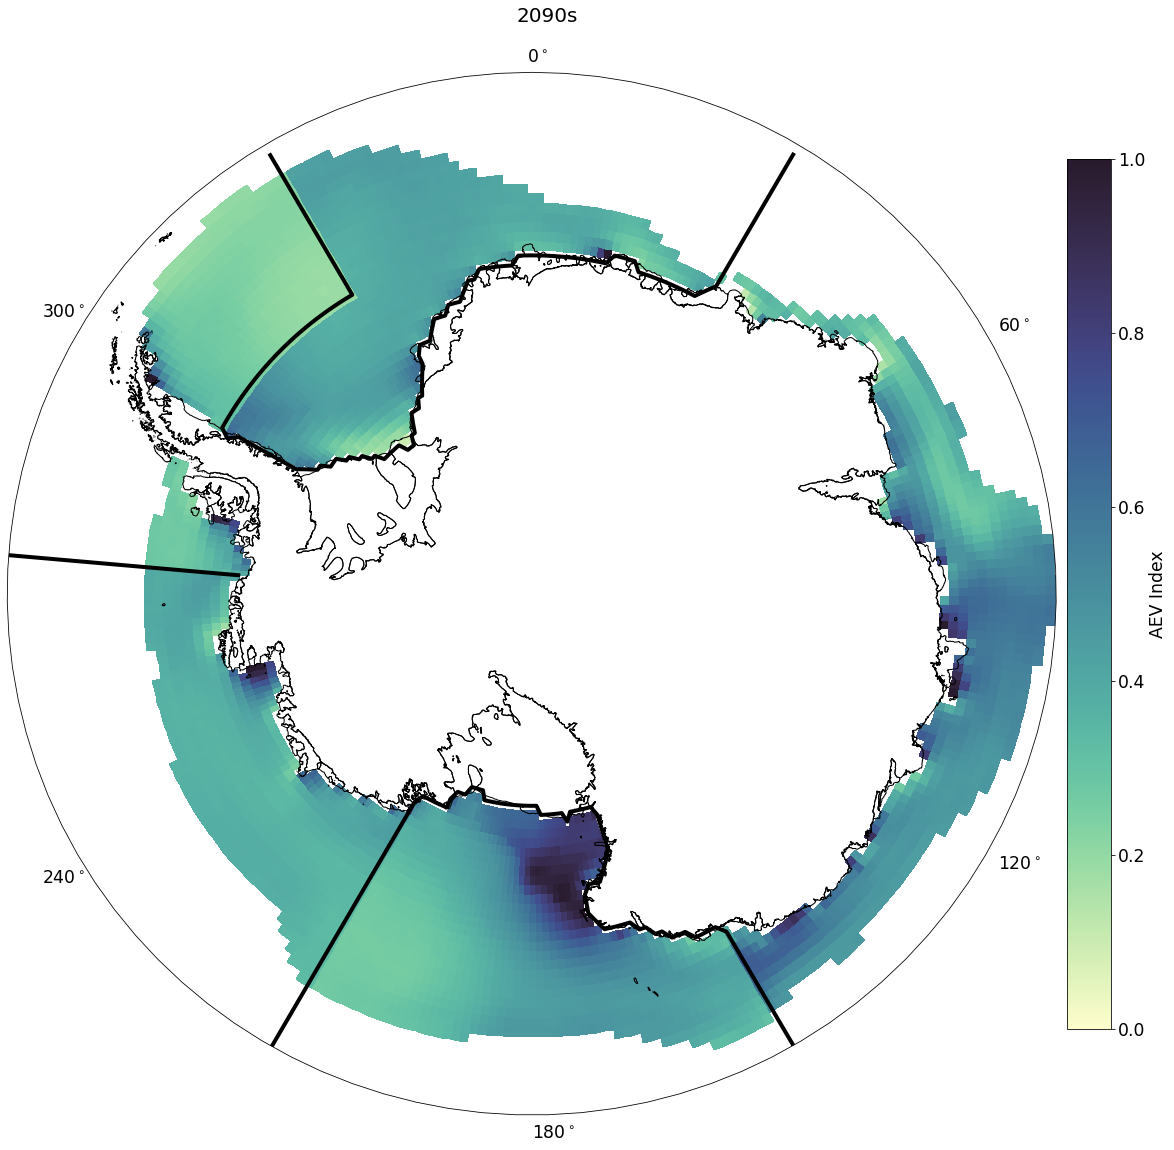

In [21]:
### Plot Regional AEV Index by decade
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2090
dec_str = str(dec)
fout = 'SFigure_AEV_region_'+dec_str

# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

# Finalize figure and save
fig.suptitle(dec_str+'s',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

# Find AEV bins
- Use statistics on each region to get top % thresholds
- Plot the results to check that these look reasonable

In [22]:
# three thresholds: top 5%, 10% and 25%
f1 = 0.05
f2 = 0.1
f3 = 0.25

# set information that will be part of bin coordinate array
bin_dim = ['5pct', '10pct','25pct']
nbins = len(bin_dim)

In [23]:
# set list of the regions we'll loop through
# weddell, east antarctica, ross sea, amundsen sea, antarctic peninsula
region_list = ['mpa_plan_3_4', 'mpa_plan_7_mod', 'mpa_plan_8', 'mpa_plan_9', 'mpa_plan_1_mod']
nreg = len(region_list)

In [24]:
# get list of decades we'll investigate
dec = eco_pd.decades
ndec = len(dec)

In [25]:
# get dimensions of nlat*nlon for histograms
npts_tot = len(eco_pd.nlat)*len(eco_pd.nlon)
print(npts_tot)

11520


### Loop through regions to get bin thresholds

In [26]:
# Examine Distribution of AEV data by region and decade to get thresholds for bins

# make array to save threshold values
bin_1 = np.ones([nreg,ndec])
bin_2 = np.ones([nreg,ndec])
bin_3 = np.ones([nreg,ndec])
data_hist = np.full((nreg,ndec,npts_tot), np.nan)

### loop through regions
for i in np.arange(0,nreg):
    print(region_list[i])
    reg=region_list[i]
    # select data for this region - it will include all decades
    data_in = eco_pd.where(ccamlr_masks.sel(region=reg) == 1)

    ### loop through decades
    for j in np.arange(0,ndec):
        # select just this decade
        data_in_new = data_in.isel(decades=j)
        # make array 1D and drop missing values
        data_1d = data_in_new.stack(xdim=("nlat","nlon"))
        # keep just this data for histogram plots
        data_hist[i,j,:] = data_1d        
        # now drop missing values
        data_1d_sub = data_1d.dropna(dim='xdim')
        # sort the array from lowest to highest
        data_1d_sort = data_1d_sub.sortby(data_1d_sub, ascending=True)
        # get the number of values in this region
        npts = data_1d_sort.shape[0]
        # find index threshold values
        ind_1 = npts - round(npts*f1)
        ind_2 = npts - round(npts*f2)
        ind_3 = npts - round(npts*f3)
        # assign arrays with bin cut offs
        bin_1[i,j] = np.round_(data_1d_sort[ind_1].values,decimals=2)
        bin_2[i,j] = np.round_(data_1d_sort[ind_2].values,decimals=2)
        bin_3[i,j] = np.round_(data_1d_sort[ind_3].values,decimals=2)

# convert to xarray and set coordinates
reg_bin_1 = xr.DataArray(bin_1,dims=('regions','decades'))
reg_bin_1['regions'] = region_list
reg_bin_1['decades'] = eco_pd.decades
reg_bin_2 = xr.DataArray(bin_2,dims=('regions','decades'))
reg_bin_2['regions'] = region_list
reg_bin_2['decades'] = eco_pd.decades
reg_bin_3 = xr.DataArray(bin_3,dims=('regions','decades'))
reg_bin_3['regions'] = region_list
reg_bin_3['decades'] = eco_pd.decades

data_hist = xr.DataArray(data_hist,dims=('regions','decades','points'))
data_hist['regions'] = region_list
data_hist['decades'] = eco_pd.decades

mpa_plan_3_4
mpa_plan_7_mod
mpa_plan_8
mpa_plan_9
mpa_plan_1_mod


## Plot Histogram Distributions

In [27]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

In [28]:
# set colors for thresholds
color1 = 'firebrick'
color2 = 'red'
color3 = 'salmon'

In [29]:
# set xaxis labels and tick marks
xarr = np.arange(0,1.1, 0.1)

SFigure_AEV_distribution_regions_2000


Text(0.5, 0.98, 'Decade: 2000s')

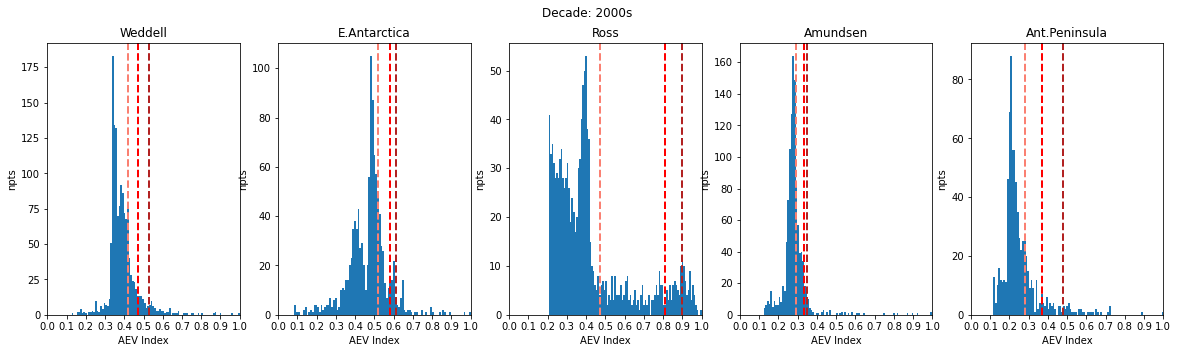

In [30]:
# Plot
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2000
dec_str = str(dec)
fout = 'SFigure_AEV_distribution_regions_'+dec_str
print(fout)

# create figure
fig = plt.figure(figsize=(20,5))

# plot the regions as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Weddell Sea region ###
name = 'Weddell'
reg = 'mpa_plan_3_4'
ax = fig.add_subplot(1,5,1)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot East Antarctic region ###
name = 'E.Antarctica'
reg = 'mpa_plan_7_mod'
ax = fig.add_subplot(1,5,2)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Ross Sea region ###
name = 'Ross'
reg = 'mpa_plan_8'
ax = fig.add_subplot(1,5,3)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Amundsen Sea region ###
name = 'Amundsen'
reg = 'mpa_plan_9'
ax = fig.add_subplot(1,5,4)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Peninsula region ###
name = 'Ant.Peninsula'
reg = 'mpa_plan_1_mod'
ax = fig.add_subplot(1,5,5)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

# Finalize figure and save
fig.suptitle('Decade: '+dec_str+'s') 
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

SFigure_AEV_distribution_regions_2030


Text(0.5, 0.98, 'Decade: 2030s')

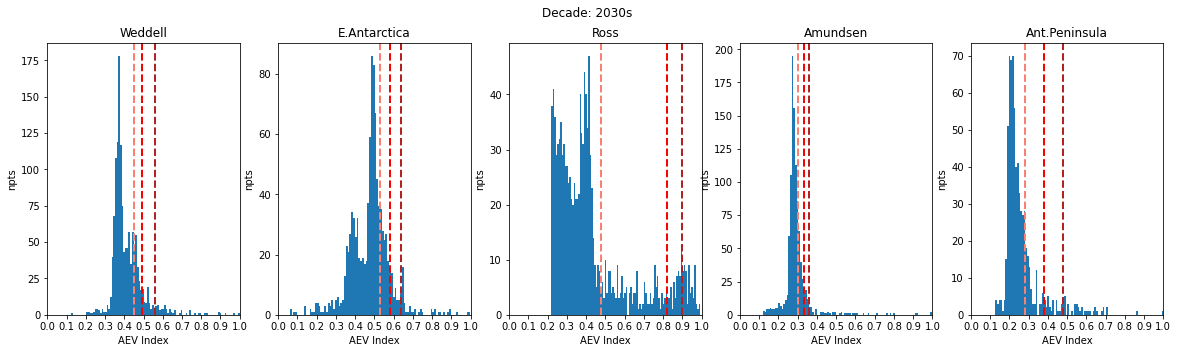

In [31]:
# Plot
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2030
dec_str = str(dec)
fout = 'SFigure_AEV_distribution_regions_'+dec_str
print(fout)

# create figure
fig = plt.figure(figsize=(20,5))

# plot the regions as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Weddell Sea region ###
name = 'Weddell'
reg = 'mpa_plan_3_4'
ax = fig.add_subplot(1,5,1)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot East Antarctic region ###
name = 'E.Antarctica'
reg = 'mpa_plan_7_mod'
ax = fig.add_subplot(1,5,2)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Ross Sea region ###
name = 'Ross'
reg = 'mpa_plan_8'
ax = fig.add_subplot(1,5,3)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Amundsen Sea region ###
name = 'Amundsen'
reg = 'mpa_plan_9'
ax = fig.add_subplot(1,5,4)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Peninsula region ###
name = 'Ant.Peninsula'
reg = 'mpa_plan_1_mod'
ax = fig.add_subplot(1,5,5)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

# Finalize figure and save
fig.suptitle('Decade: '+dec_str+'s') 
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

SFigure_AEV_distribution_regions_2060


Text(0.5, 0.98, 'Decade: 2060s')

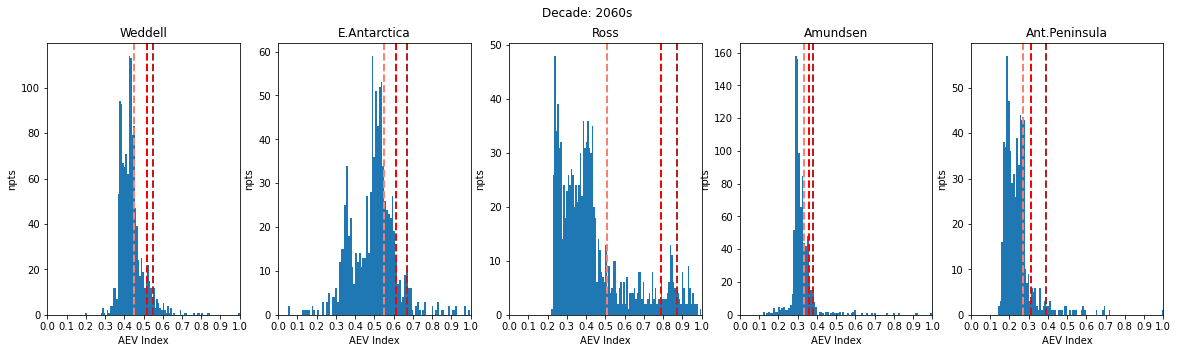

In [32]:
# Plot
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2060
dec_str = str(dec)
fout = 'SFigure_AEV_distribution_regions_'+dec_str
print(fout)

# create figure
fig = plt.figure(figsize=(20,5))

# plot the regions as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Weddell Sea region ###
name = 'Weddell'
reg = 'mpa_plan_3_4'
ax = fig.add_subplot(1,5,1)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot East Antarctic region ###
name = 'E.Antarctica'
reg = 'mpa_plan_7_mod'
ax = fig.add_subplot(1,5,2)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Ross Sea region ###
name = 'Ross'
reg = 'mpa_plan_8'
ax = fig.add_subplot(1,5,3)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Amundsen Sea region ###
name = 'Amundsen'
reg = 'mpa_plan_9'
ax = fig.add_subplot(1,5,4)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Peninsula region ###
name = 'Ant.Peninsula'
reg = 'mpa_plan_1_mod'
ax = fig.add_subplot(1,5,5)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

# Finalize figure and save
fig.suptitle('Decade: '+dec_str+'s') 
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

SFigure_AEV_distribution_regions_2090


Text(0.5, 0.98, 'Decade: 2090s')

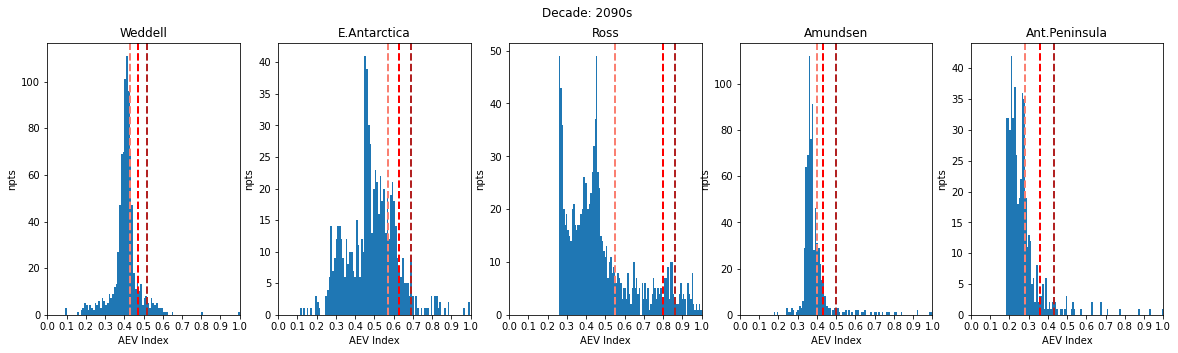

In [33]:
# Plot
# set decade to plot - 2000, 2030, 2060, 2090
dec = 2090
dec_str = str(dec)
fout = 'SFigure_AEV_distribution_regions_'+dec_str
print(fout)

# create figure
fig = plt.figure(figsize=(20,5))

# plot the regions as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Weddell Sea region ###
name = 'Weddell'
reg = 'mpa_plan_3_4'
ax = fig.add_subplot(1,5,1)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot East Antarctic region ###
name = 'E.Antarctica'
reg = 'mpa_plan_7_mod'
ax = fig.add_subplot(1,5,2)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Ross Sea region ###
name = 'Ross'
reg = 'mpa_plan_8'
ax = fig.add_subplot(1,5,3)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Amundsen Sea region ###
name = 'Amundsen'
reg = 'mpa_plan_9'
ax = fig.add_subplot(1,5,4)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

### Plot Peninsula region ###
name = 'Ant.Peninsula'
reg = 'mpa_plan_1_mod'
ax = fig.add_subplot(1,5,5)
ax.set_title(name)
data_1d = data_hist.sel(decades=dec,regions=reg).dropna(dim='points')
this=ax.hist(data_1d, bins=100)
# add axis formatting
plt.xlabel('AEV Index')
plt.xlim(0,1.0)
plt.xticks(xarr)
plt.ylabel('npts')
# add high and exceptional lines
plt.axvline(x=reg_bin_1.sel(decades=dec,regions=reg), color=color1, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_2.sel(decades=dec,regions=reg), color=color2, linestyle='--',linewidth=2)
plt.axvline(x=reg_bin_3.sel(decades=dec,regions=reg), color=color3, linestyle='--',linewidth=2)

# Finalize figure and save
fig.suptitle('Decade: '+dec_str+'s') 
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

## Make and save masks of these threshold values
- Save these as netcdf files for use in plots and statistics

In [34]:
# Now get make masks in each bin by region

# make array to save masks by each bin
data_1 = np.ones([nreg,ndec,len(data_in.nlat),len(data_in.nlon)])
data_2 = np.ones([nreg,ndec,len(data_in.nlat),len(data_in.nlon)])
data_3 = np.ones([nreg,ndec,len(data_in.nlat),len(data_in.nlon)])
data_tmp = np.ones([len(data_in.nlat),len(data_in.nlon)])
data_tmp = xr.DataArray(data_tmp,dims=('nlat','nlon'))

### loop through regions
for i in np.arange(0,nreg):
    print(region_list[i])
    reg=region_list[i]
    # select data for this region - it will include all decades
    data_in = eco_pd.where(ccamlr_masks.sel(region=reg) == 1)

    ### loop through decades
    for j in np.arange(0,ndec):
        # select just this decade
        data_in_new = data_in.isel(decades=j)
        # select thresholds for this region and decade
        thresh_1 = reg_bin_1[i,j]
        thresh_2 = reg_bin_2[i,j]
        thresh_3 = reg_bin_3[i,j]    
        # make mask for this data for each threshold
        data_1[i,j,:,:] = data_tmp.where( (data_in_new >= thresh_1))
        data_2[i,j,:,:]  = data_tmp.where( (data_in_new >= thresh_2) & (data_in_new < thresh_1))
        data_3[i,j,:,:]  = data_tmp.where( (data_in_new >= thresh_3) & (data_in_new < thresh_2))

# convert to xarray and set coordinates
data_bin_1 = xr.DataArray(data_1,dims=('regions','decades','nlat','nlon'))
data_bin_1['regions'] = region_list
data_bin_1['decades'] = eco_pd.decades
data_bin_1['nlat'] = eco_pd.nlat
data_bin_1['nlon'] = eco_pd.nlon
data_bin_2 = xr.DataArray(data_2,dims=('regions','decades','nlat','nlon'))
data_bin_2['regions'] = region_list
data_bin_2['decades'] = eco_pd.decades
data_bin_2['nlat'] = eco_pd.nlat
data_bin_2['nlon'] = eco_pd.nlon
data_bin_3 = xr.DataArray(data_3,dims=('regions','decades','nlat','nlon'))
data_bin_3['regions'] = region_list
data_bin_3['decades'] = eco_pd.decades
data_bin_3['nlat'] = eco_pd.nlat
data_bin_3['nlon'] = eco_pd.nlon

# concatentate into a single xarray and set dimensions
aev_bins_all_separate = xr.concat([data_bin_1,data_bin_2,data_bin_3], dim = 'bin')
aev_bins_all_separate['bin'] = bin_dim

mpa_plan_3_4
mpa_plan_7_mod
mpa_plan_8
mpa_plan_9
mpa_plan_1_mod


In [35]:
# Combine the individual regions into a single mask with the three levels

# make arrays
reg_bins = np.ones([ndec,len(data_in.nlat),len(data_in.nlon)])
reg_bins = xr.DataArray(reg_bins,dims=('decades','nlat','nlon'))

# make 5% mask
tmp1 = data_bin_1.isel(regions=0).fillna(0)
tmp2 = data_bin_1.isel(regions=1).fillna(0)
tmp3 = data_bin_1.isel(regions=2).fillna(0)
tmp4 = data_bin_1.isel(regions=3).fillna(0)
tmp5 = data_bin_1.isel(regions=4).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_5 = tmp.where(tmp == 1)
# make 10% mask
tmp1 = data_bin_2.isel(regions=0).fillna(0)
tmp2 = data_bin_2.isel(regions=1).fillna(0)
tmp3 = data_bin_2.isel(regions=2).fillna(0)
tmp4 = data_bin_2.isel(regions=3).fillna(0)
tmp5 = data_bin_2.isel(regions=4).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_10 = tmp.where(tmp == 1)
# make 25% mask
tmp1 = data_bin_3.isel(regions=0).fillna(0)
tmp2 = data_bin_3.isel(regions=1).fillna(0)
tmp3 = data_bin_3.isel(regions=2).fillna(0)
tmp4 = data_bin_3.isel(regions=3).fillna(0)
tmp5 = data_bin_3.isel(regions=4).fillna(0)
tmp = tmp1+tmp2+tmp3+tmp4+tmp5
reg_25 = tmp.where(tmp == 1)

# concatentate into a single xarray and set dimensions
aev_bins_region = xr.concat([reg_5,reg_10,reg_25], dim = 'bin')
aev_bins_region['nlat'] = data_in.nlat
aev_bins_region['nlon'] = data_in.nlon
aev_bins_region['bin'] = bin_dim

### Save these data into a single file

In [36]:
ds_out = xr.Dataset()

ds_out['aev_bins_region'] = aev_bins_region
ds_out['aev_bins_all_separate'] = aev_bins_all_separate
ds_out['reg_bin_1'] = reg_bin_1
ds_out['reg_bin_2'] = reg_bin_2
ds_out['reg_bin_3'] = reg_bin_3
ds_out['REGION_MASK'] = ds_grid.REGION_MASK

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Ecological Index Bins for - decadal for present and future. For each region the exceptional, very high, and high bins based on PDF.'
ds_out.attrs['units'] = f'Unitless'

ds_out

<xarray.Dataset>
Dimensions:                (decades: 14, nlat: 36, nlon: 320, regions: 5, bin: 3)
Coordinates:
  * decades                (decades) int64 1960 1970 1980 ... 2070 2080 2090
  * nlat                   (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                   (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
  * regions                (regions) <U14 'mpa_plan_3_4' ... 'mpa_plan_1_mod'
    region                 <U14 'mpa_plan_1_mod'
  * bin                    (bin) <U5 '5pct' '10pct' '25pct'
    ULONG                  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT                   (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG                  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                   (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    aev_bins_region        (bin, decades, nlat, nlon) float64 nan nan ... nan
    aev_bins_all_separate  (bin, regions, decades, nlat, nlon) float64 nan .....
    reg_bin_1              (regions, decades) float64 0.49 0.5 ... 0.41 0.43
    reg_bin_2              (regions, decades) float64 0.42 0.43 ... 0.33 0.36
    reg_bin_3              (regions, decades) float64 0.37 0.38 ... 0.27 0.28
    REGION_MASK            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-10
    contents:        Ecological Index Bins for - decadal for present and futu...
    units:           Unitless

In [37]:
# drop unnecessary coordinates
ds_out = ds_out.drop('region')
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [38]:
ds_out

<xarray.Dataset>
Dimensions:                (decades: 14, nlat: 36, nlon: 320, regions: 5, bin: 3)
Coordinates:
  * decades                (decades) int64 1960 1970 1980 ... 2070 2080 2090
  * nlat                   (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                   (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
  * regions                (regions) <U14 'mpa_plan_3_4' ... 'mpa_plan_1_mod'
  * bin                    (bin) <U5 '5pct' '10pct' '25pct'
    TLONG                  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                   (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    aev_bins_region        (bin, decades, nlat, nlon) float64 nan nan ... nan
    aev_bins_all_separate  (bin, regions, decades, nlat, nlon) float64 nan .....
    reg_bin_1              (regions, decades) float64 0.49 0.5 ... 0.41 0.43
    reg_bin_2              (regions, decades) float64 0.42 0.43 ... 0.33 0.36
    reg_bin_3              (regions, decades) float64 0.37 0.38 ... 0.27 0.28
    REGION_MASK            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-10
    contents:        Ecological Index Bins for - decadal for present and futu...
    units:           Unitless

In [39]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	decades: (14,)
	nlat: (36,)
	nlon: (320,)
	regions: (5,)
	bin: (3,)
Coordinates:
	decades:
		[1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090]
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170

In [40]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.02 GB.


In [41]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'
file_out = 'ecoindex_historical_future_bins.nc'
fout = path_out + file_out

In [42]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)